In [72]:
%matplotlib inline 


import numpy as np

import pandas as pd
from lid_driven_cavity_flow_pinn.utils import generate_csv_catalog, read_datafile, get_boundary_samples
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import torch



In [35]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


## Generate the dataset

In this randomly generated dataset I decided to have just a tablular type output with 50,000 samples, 60 features (highly dimensional), and 25 being redundent information for the random and boosted trees.

In [36]:
# Generate the dataset with the number of samples and features with some being redundent and others being useful information
# Input, Response = make_classification(n_samples=50000, n_features=35+25, n_informative=35, n_redundant=25, random_state=7406)

catalog = generate_csv_catalog()

catalog

                        filepath   Re  xsize  ysize
1879      ../data/Re300/PUV0.txt  300    151    151
1880    ../data/Re300/PUV100.txt  300    151    151
1881   ../data/Re300/PUV1000.txt  300    151    151
1882  ../data/Re300/PUV10000.txt  300    151    151
1883  ../data/Re300/PUV10100.txt  300    151    151 
 number of files cataloged: 4850



,filepath,Re,xsize,ysize
1879,../data/Re300/PUV0.txt,300,151,151
1880,../data/Re300/PUV100.txt,300,151,151
1881,../data/Re300/PUV1000.txt,300,151,151
1882,../data/Re300/PUV10000.txt,300,151,151
1883,../data/Re300/PUV10100.txt,300,151,151
...,...,...,...,...
1874,../data/Re2000/PUV9500.txt,2000,151,151
1875,../data/Re2000/PUV9600.txt,2000,151,151
1876,../data/Re2000/PUV9700.txt,2000,151,151
1877,../data/Re2000/PUV9800.txt,2000,151,151


In [37]:
# pull out a single file and check it out.
P, U, V, time, Re = read_datafile(catalog.iloc[1800]["filepath"])
print("total data points in a single file", P.flatten().shape[0] + U.flatten().shape[0] + V.flatten().shape[0])



total data points in a single file 68403


In [38]:
get_boundary_samples(P).shape[0]



600

In [6]:
# computational boundary
x_lower, x_upper, y_lower, y_upper = 0, 1, -1, 0

# make a new dataframe with all the data in it
P_list, U_list, V_list, time_list, Re_list = [], [], [], [], []
P_boundary_list, U_boundary_list, V_boundary_list = [], [], []
catalog_dict = catalog.to_dict("records")
for file in tqdm(catalog_dict):
    P, U, V, time, Re = read_datafile(file["filepath"])
    
    # stash all of them
    P_list.append(P.flatten())
    U_list.append(U.flatten())
    V_list.append(V.flatten())
    # select just the boundary points
    P_boundary_list.append(get_boundary_samples(P))
    U_boundary_list.append(get_boundary_samples(U))
    V_boundary_list.append(get_boundary_samples(V))
    # don't forget the time and response variable
    # time_list.append(time.flatten()[0])
    Re_list.append(Re)
    
P_df = pd.DataFrame(P_list)
U_df = pd.DataFrame(U_list)
V_df = pd.DataFrame(V_list)
P_boundary_df = pd.DataFrame(P_boundary_list)
U_boundary_df = pd.DataFrame(U_boundary_list)
V_boundary_df = pd.DataFrame(V_boundary_list)
# time_df = pd.DataFrame(time_list)
Re_df = pd.DataFrame(Re_list)


# put together the whole array
P_df_al = pd.concat([P_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)
U_df_al = pd.concat([U_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)
V_df_al = pd.concat([V_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)

# put together just the boundary list
P_boundary_df_al = pd.concat([P_boundary_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)
U_boundary_df_al = pd.concat([U_boundary_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)
V_boundary_df_al = pd.concat([V_boundary_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)



    

  0%|          | 0/4850 [00:00<?, ?it/s]

In [39]:
# do some relabeling
Re_df = Re_df.rename(columns={0:"Re"})
Re_df.Re.astype("category")

Re_dummy = pd.get_dummies(Re_df.Re)
Re_dummy

,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4845,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4848,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [40]:
V_df_al_arr = P_df_al.iloc[:,:-1].to_numpy()
# norm_pres = V_df_al_arr/np.linalg.norm(V_df_al_arr)

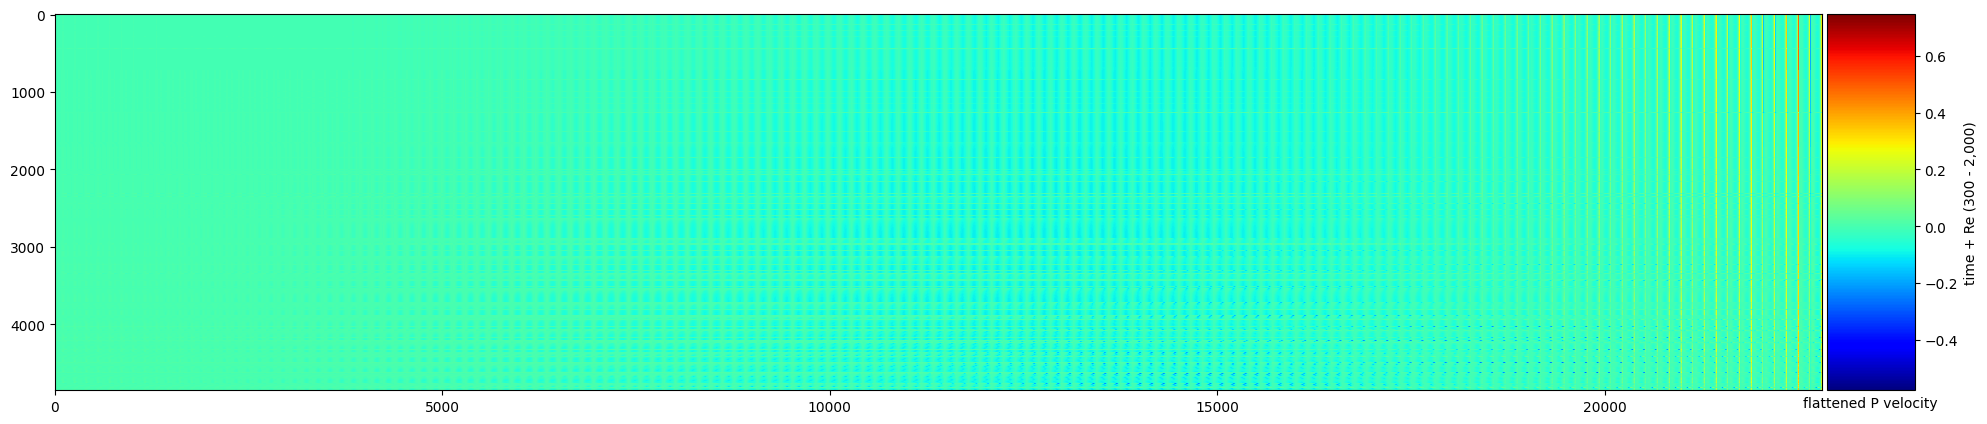

In [45]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(24,24))
im = ax.imshow(P_df_al.iloc[:,:-1].to_numpy(), cmap="jet",interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, orientation='vertical', cax=cax)
plt.ylabel("time + Re (300 - 2,000)")
plt.xlabel("flattened P velocity")
plt.savefig("../images/P_flattened_y_time_Re_colorbar.png", bbox_inches="tight", dpi=300)

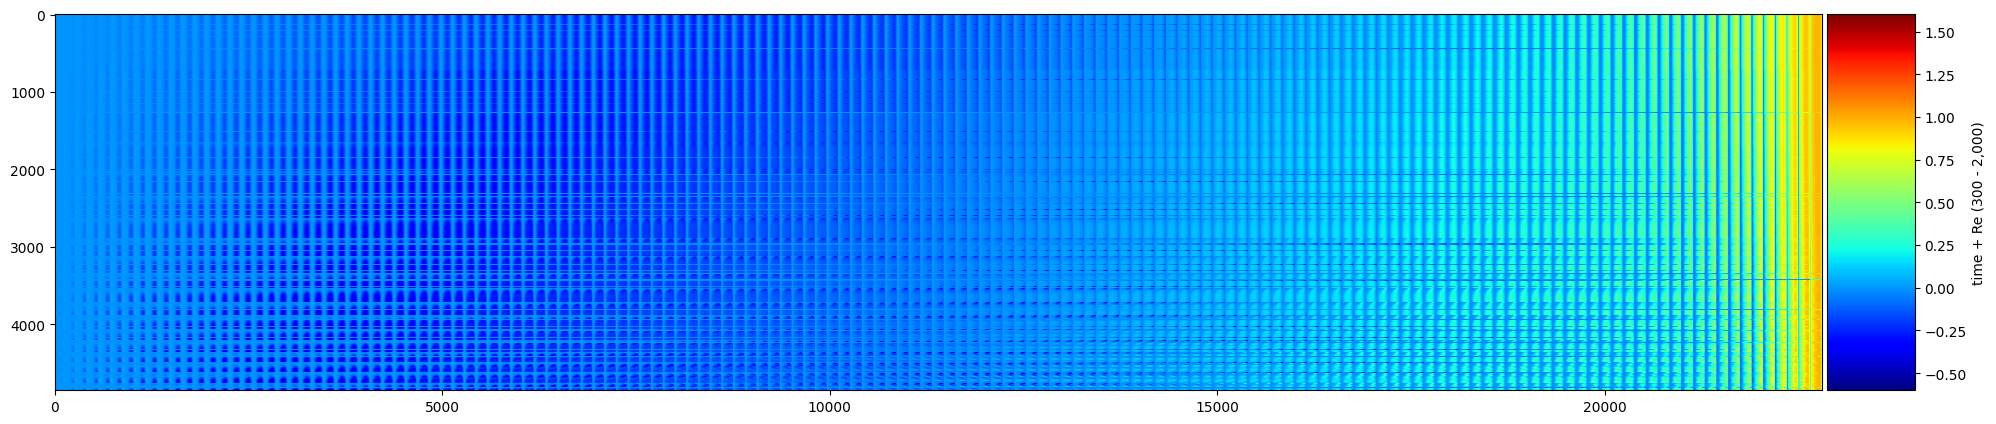

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(24,24))
im = ax.imshow(U_df_al.iloc[:,:-1].to_numpy(), cmap="jet",interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, orientation='vertical', cax=cax)
plt.ylabel("time + Re (300 - 2,000)")
plt.savefig("../images/U_flattened_y_time_Re_colorbar.png", bbox_inches="tight", dpi=300)

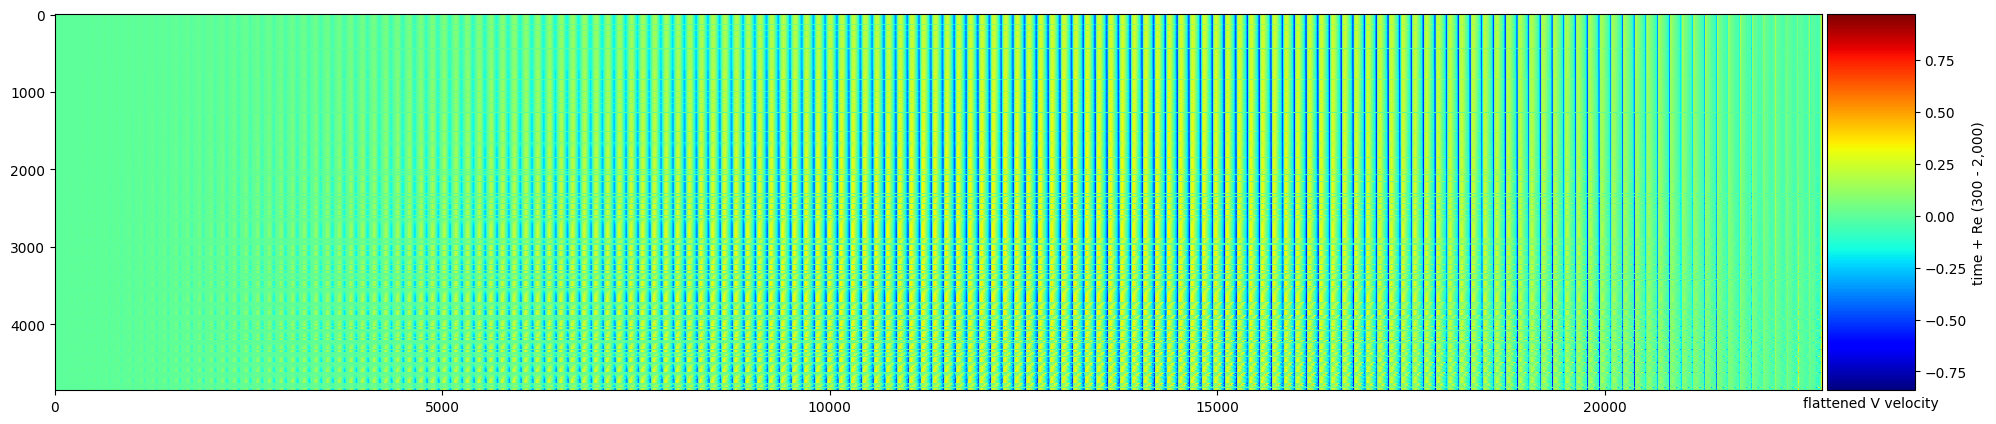

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(24,24))
im = ax.imshow(V_df_al.iloc[:,:-1].to_numpy(), cmap="jet",interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, orientation='vertical', cax=cax)
plt.ylabel("time + Re (300 - 2,000)")
plt.xlabel("flattened V velocity")
plt.savefig("../images/V_flattened_y_time_Re_colorbar.png", bbox_inches="tight", dpi=300)

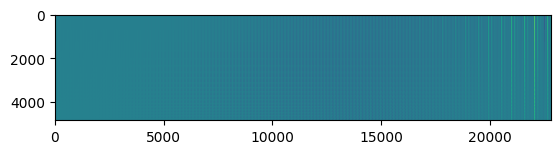

In [48]:
plt.imshow(np.array(P_list))

From the output above it's worth noting the dataset is binary! (either 0 or 1)

Now let's split this into a test and train split, and do stratified cross-validation on the training dataset!

# Random Forest Classifier

Alrighty, now that the test and train data is split, let's train some models!

In [89]:
# Setup the data, train first half, test second half
P_bound_data_train = np.split(P_boundary_df_al, 2, axis=0)[0]
P_bound_data_test = np.split(P_boundary_df_al, 2, axis=0)[1]
U_bound_data_train = np.split(U_boundary_df_al, 2, axis=0)[0]
U_bound_data_test = np.split(U_boundary_df_al, 2, axis=0)[1]
V_bound_data_train = np.split(V_boundary_df_al, 2, axis=0)[0]
V_bound_data_test = np.split(V_boundary_df_al, 2, axis=0)[1]

# all 
print("all, shape", P_df_al.shape)

Input_all_train_p = np.split(P_df_al, 2, axis=0)[0]
Input_all_test_p = np.split(P_df_al, 2, axis=0)[1]
Input_all_train_u = np.split(U_df_al, 2, axis=0)[0]
Input_all_test_u = np.split(U_df_al, 2, axis=0)[1]
Input_all_train_v = np.split(V_df_al, 2, axis=0)[0]
Input_all_test_v = np.split(V_df_al, 2, axis=0)[1]

Input_train_all = pd.concat([Input_all_train_p, Input_all_train_u, Input_all_train_v], axis=1)
Input_test_all = pd.concat([Input_all_test_p, Input_all_test_u, Input_all_test_v], axis=1)

# boundary
Input_boundary_train_p = np.split(P_boundary_df_al, 2, axis=0)[0]
Input_boundary_test_p = np.split(P_boundary_df_al, 2, axis=0)[1]
Input_boundary_train_u = np.split(U_boundary_df_al, 2, axis=0)[0]
Input_boundary_test_u = np.split(U_boundary_df_al, 2, axis=0)[1]
Input_boundary_train_v = np.split(V_boundary_df_al, 2, axis=0)[0]
Input_boundary_test_v = np.split(V_boundary_df_al, 2, axis=0)[1]

Input_boundary_train = pd.concat([Input_boundary_train_p, Input_boundary_train_u, Input_boundary_train_v], axis=1)
Input_boundary_test = pd.concat([Input_boundary_test_p, Input_boundary_test_u, Input_boundary_test_v], axis=1)


# boundary with 10% randomly selected
rand_select = np.random.randint(P_bound_data_train.shape[1], size=60)
Input_boundary_10_random_train_p = P_bound_data_train[np.intersect1d(P_bound_data_train.columns, rand_select)]
Input_boundary_10_random_test_p  = P_bound_data_test[np.intersect1d(P_bound_data_train.columns, rand_select)]
Input_boundary_10_random_train_u = U_bound_data_train[np.intersect1d(U_bound_data_train.columns, rand_select)]
Input_boundary_10_random_test_u  = U_bound_data_test[np.intersect1d(U_bound_data_train.columns, rand_select)]
Input_boundary_10_random_train_v = V_bound_data_train[np.intersect1d(V_bound_data_train.columns, rand_select)]
Input_boundary_10_random_test_v  = V_bound_data_test[np.intersect1d(V_bound_data_train.columns, rand_select)]

Input_boundary_10_random_train = pd.concat([Input_boundary_10_random_train_p, Input_boundary_10_random_train_u, Input_boundary_10_random_train_v], axis=1)
Input_boundary_10_random_test = pd.concat([Input_boundary_10_random_test_p, Input_boundary_10_random_test_u, Input_boundary_10_random_test_v], axis=1)


# print(Input_all_train.dtype)
Re_dummy_train = np.split(Re_dummy, 2, axis=0)[0]
Re_dummy_test = np.split(Re_dummy, 2, axis=0)[1]
Re_train = np.split(Re_df, 2, axis=0)[0]
Re_test = np.split(Re_df, 2, axis=0)[1]
print(Input_train_all.shape, Input_boundary_train.shape, Input_boundary_10_random_train.shape, Re_dummy_train.shape)
print(type(Input_train_all), type(Re_dummy_train))

all, shape (4850, 22802)
(2425, 68406) (2425, 1803) (2425, 171) (2425, 18)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [61]:
Input_train_all.dtypes

0        float64
1        float64
2        float64
3        float64
4        float64
          ...   
22797    float64
22798    float64
22799    float64
22800    float64
0          int64
Length: 68406, dtype: object

In [78]:

RandomForestModel_all = RandomForestClassifier(n_jobs=-1, n_estimators=10000, bootstrap=True,
                      random_state=7406).fit(Input_train_all.to_numpy()[:, :-1], Re_dummy_train)
print(RandomForestModel_all)
RandomForestModel_boundary = RandomForestClassifier(bootstrap=True, n_estimators=10000,
                      n_jobs=-1,
                      random_state=7406).fit(Input_boundary_train.to_numpy()[:, :-1], Re_dummy_train)
RandomForestModel_boundary_10_random_select = RandomForestClassifier( n_estimators=10000,bootstrap=True,
                      n_jobs=-1,
                      random_state=7406).fit(Input_boundary_10_random_train.to_numpy()[:, :-1], Re_dummy_train)



RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=7406)


In [ ]:
# assess the model
# Create confusion matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# print(confusion_matrix(Re_dummy_test, RandomForestModel_all.predict(Input_test_all.to_numpy()[:, :-1])))
# Display accuracy score
print(accuracy_score(Re_dummy_test, RandomForestModel_all.predict(Input_test_all.to_numpy()[:, :-1])) * 100)
print(accuracy_score(Re_dummy_test, RandomForestModel_boundary.predict(Input_boundary_test.to_numpy()[:, :-1]))* 100)
print(accuracy_score(Re_dummy_test, RandomForestModel_boundary_10_random_select.predict(Input_boundary_10_random_test.to_numpy()[:, :-1]))* 100)
# Display F1 score
print("f1 score:", f1_score(Re_dummy_test, RandomForestModel_all.predict(Input_boundary_10_random_test.to_numpy()[:, :-1]), average='weighted'))
print("f1 score:", f1_score(Re_dummy_test, RandomForestModel_boundary.predict(Input_boundary_10_random_test.to_numpy()[:, :-1]), average='weighted'))
print("f1 score:", f1_score(Re_dummy_test, RandomForestModel_boundary_10_random_select.predict(Input_boundary_10_random_test.to_numpy()[:, :-1]), average='weighted'))


8.164948453608249
8.494845360824742
8.082474226804123
f1 score: 0.023397716146665058


/home/bartelsaa/miniconda3/envs/lid_driven_cavity_flow_pin/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Hey! 95.6% accuracy, that's not bad at all! 


# Gradient Boosting Classifier

Now let's check out the same thing but for an `sklearn` boosting model such as the Gradient Boosting Classifier

In [91]:
GradBoostingClassModel_all = GradientBoostingClassifier(n_estimators=100,
                      random_state=7406).fit(Input_train_all.to_numpy()[:, :-1], Re_train.to_numpy())

GradBoostingClassModel_boundary = GradientBoostingClassifier(n_estimators=100,
                      random_state=7406).fit(Input_boundary_train.to_numpy()[:, :-1], Re_train.to_numpy())
GradBoostingClassModel_boundary_10_random_select = GradientBoostingClassifier( n_estimators=100,
                      random_state=7406).fit(Input_boundary_10_random_train.to_numpy()[:, :-1], Re_train.to_numpy())

/home/bartelsaa/miniconda3/envs/lid_driven_cavity_flow_pin/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bartelsaa/miniconda3/envs/lid_driven_cavity_flow_pin/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/bartelsaa/miniconda3/envs/lid_driven_cavity_flow_pin/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [101]:
# assess the model
# Create confusion matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# print(confusion_matrix(Re_dummy_test, RandomForestModel_all.predict(Input_test_all.to_numpy()[:, :-1])))
# Display accuracy score
print(accuracy_score(Re_test, GradBoostingClassModel_all.predict(Input_test_all.to_numpy()[:, :-1])) * 100)
print(accuracy_score(Re_test, GradBoostingClassModel_boundary.predict(Input_boundary_test.to_numpy()[:, :-1]))* 100)
print(accuracy_score(Re_test, GradBoostingClassModel_boundary_10_random_select.predict(Input_boundary_10_random_test.to_numpy()[:, :-1]))* 100)
# Display F1 score
pred_Re_gradBoost = GradBoostingClassModel_boundary_10_random_select.predict(Input_boundary_10_random_test.to_numpy()[:, :-1])
print(pred_Re_gradBoost.shape)
print("shape:", Input_boundary_10_random_test.to_numpy()[:, :-1].shape, Input_boundary_10_random_train.to_numpy()[:, :-1].shape)
print("f1 score:", f1_score(Re_test, pred_Re_gradBoost, average='weighted'))
# print("f1 score:", f1_score(Re_test, GradBoostingClassModel_boundary.predict(Input_boundary_10_random_test.to_numpy()[:, :-1]), average='weighted'))
# print("f1 score:", f1_score(Re_test, GradBoostingClassModel_boundary_10_random_select.predict(Input_boundary_10_random_test.to_numpy()[:, :-1]), average='weighted'))



11.752577319587628
11.752577319587628
11.752577319587628
(2425,)
shape: (2425, 170) (2425, 170)
f1 score: 0.024719443070719365


# Logistic Regression

In [ ]:
logreg = LogisticRegression(C=1e5)

n_scores = cross_val_score(logreg, Input_train, Response_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
logreg_nocv = LogisticRegression(C=1e5).fit(Input_train, Response_train)

In [ ]:
print('the Random Forest test accuracy:', (RandomForestModel_nocv.score(Input_test, Response_test))) 
print('the Gradient Boosting test accuracy:', (GradBoostingClassModel_nocv.score(Input_test, Response_test))) 
print('the Logistic Regression test accuracy:', (logreg_nocv.score(Input_test, Response_test))) 

## PINN


In [ ]:
from collections import OrderedDict

# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f